plot chromHMM

In [1]:
# python modules
import sys
import copy
import re
import random
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
from scipy import stats


In [2]:
# custom modules
sys.path.append('/Users/sangwoopark/Projects/condense-seq/postpro_scripts')
import graphics_edit as graphics
import load_file_edit as load_file
import Interval_dict
import statis_edit as statis


In [3]:
# matplotlib setting
%matplotlib inline
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"


In [4]:
### parameters
cell_org = {'H1':'human',
            'GM':'human',
            'mCD8T:WT':'mouse',
            'mCD8T:DFMO':'mouse',
            'mCD8T:ODCKO':'mouse'}

cell_chrnames = {'H1':['chr%s' % (i) for i in range(1, 23)] + ['chrX', 'chrY'],
                 'GM':['chr%s' % (i) for i in range(1, 23)] + ['chrX'],
                 'mCD8T:WT':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:DFMO':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:ODCKO':['chr%s' % (i) for i in range(1, 20)] + ['chrX']}


In [5]:
agent_fullname = {'sp':'Spermine(4+)',
                  'spd':'Spermidine(3+)',
                  'CoH':'Cobalt Hexammine(3+)',
                  'PEG':'PEG 8000',
                  'HP1a':'HP1$\\alpha$',
                  'HP1bSUV':'HP1$\\beta$+tSUV',
                  'LKH':'Linker histone1',
                  'Ki67':'Ki67',
                  'FUS':'FUS',
                  'Mg':'Magnesium',
                  'Ca':'Calcium'}


In [6]:
## for H1
H1_name_dict = {"E1":"Polycomb repressed",
                "E2":"Poised promoter",
                "E3":"Weak promoter",
                "E4":"Strong enhancer",
                "E5":"Active promoter",
                "E6":"Weak enhancer",
                "E7":"Quiescence1",
                "E8":"Quiescence2",
                "E9":"Heterochromatin",
                "E10":"Tx elongation",
                "E11":"Weak Tx",
                "E12":"Insulator"}

# state for H1
H1_states = ["Active promoter", "Weak promoter", "Poised promoter", "Strong enhancer", "Weak enhancer", "Tx elongation", "Weak Tx", "Insulator", "Polycomb repressed", "Heterochromatin", "Quiescence1", "Quiescence2"]

H1_HMM_fname = "H1_12_segments.bed"


In [7]:
# for GM12878
GM_name_dict = {"E1":"Polycomb repressed",
                "E2":"Quiescence",
                "E3":"Heterochromatin",
                "E4":"Weak Tx",
                "E5":"Tx elongation",
                "E6":"Weak enhancer",
                "E7":"Active enhancer",
                "E8":"Strong enhancer",
                "E9":"Active promoter",
                "E10":"Weak promoter",
                "E11":"Poised promoter",
                "E12":"Insulator"}

# state for GM
GM_states = ["Active promoter", "Weak promoter", "Poised promoter", "Strong enhancer", "Active enhancer", "Weak enhancer", "Tx elongation", "Weak Tx", "Insulator", "Polycomb repressed", "Heterochromatin", "Quiescence"]

GM_HMM_fname = "GM12878_12_segments.bed"


In [8]:
# for mouse CD8 T cell
mCD8T_name_dict = {"E1":"Weak Tx",
                   "E2":"Tx elongation",
                   "E3":"Weak enhancer2",
                   "E4":"Strong enhancer2",
                   "E5":"Strong enhancer1",
                   "E6":"Weak enhancer1",
                   "E7":"Active promoter",
                   "E8":"Poised promoter",
                   "E9":"Polycomb repressed1",
                   "E10":"Polycomb repressed2",
                   "E11":"Quiescence",
                   "E12":"Heterochromatin"}

# state for mouse CD8 T cell
mCD8T_states = ["Active promoter", "Poised promoter", "Strong enhancer1", "Strong enhancer2", "Weak enhancer1", "Weak enhancer2", "Tx elongation", "Weak Tx", "Polycomb repressed1", "Polycomb repressed2", "Heterochromatin", "Quiescence"]

mCD8T_HMM_fname = "Mouse CD8 T cell (invitro activated)_12_segments.bed"


In [9]:
# data path
#path = './data/'
path = '/Users/sangwoopark/jhu_rockfish/2024_01_05_GEO/processed_files/'
chromHMM_path = '/Users/sangwoopark/jhu_rockfish/chromHMM_data/'

In [10]:
# chromHMM data set
cell_chromHMM = {'H1':[H1_HMM_fname, H1_name_dict, H1_states],
                 'GM':[GM_HMM_fname, GM_name_dict, GM_states],
                 'mCD8T':[mCD8T_HMM_fname, mCD8T_name_dict, mCD8T_states]}


In [11]:
### set target cell
cell = 'H1'

In [12]:
### set target chromosomesx
#chr_choices = cell_chromHMM['H1']
chr_choices = ['chr1']

In [13]:
### load gtab file
gtab_path = '/Users/sangwoopark/jhu_rockfish/2024_01_05_GEO/processed_files/'

gtab_path = "/Users/sangwoopark/jhu_rockfish/2024_01_05_GEO/processed_files/"
dinfo_dkey = {'H1_NCP_sp_1rep_10kb_zscore.gtab.gz':
              {'H1_NCP_sp_8_1rep':(1, 'H1', 'NCP', 'sp', 8)},
              'H1_NCP_spd_1rep_10kb_zscore.gtab.gz':
              {'H1_NCP_spd_6_1rep':(1, 'H1', 'NCP', 'spd', 6)},
              'H1_NCP_CoH_1rep_10kb_zscore.gtab.gz':
              {'H1_NCP_CoH_5_1rep':(1, 'H1', 'NCP', 'CoH', 5)},
              'H1_NCP_PEG_1rep_10kb_zscore.gtab.gz':
              {'H1_NCP_PEG_6_1rep':(1, 'H1', 'NCP', 'PEG', 6)},
              'H1_NCP_Ca_1rep_10kb_zscore.gtab.gz':
              {'H1_NCP_Ca_5_1rep':(1, 'H1', 'NCP', 'Ca', 5)},
              'H1_NCP_HP1a_1rep_10kb_zscore.gtab.gz':
              {'H1_NCP_HP1a_3_1rep':(1, 'H1', 'NCP', 'HP1a', 3)},
              'H1_NCP_HP1bSUV_1rep_10kb_zscore.gtab.gz':
              {'H1_NCP_HP1bSUV_4_1rep':(1, 'H1', 'NCP', 'HP1bSUV', 4)}}

dkey_chr_ID_value = load_file.read_gtab_batch(dinfo_dkey,
                                              data_path=gtab_path,
                                              chr_choices=chr_choices,
                                              by_chr=True)

loading H1_NCP_spd_1rep_10kb_zscore.gtab.gz


loading H1_NCP_PEG_1rep_10kb_zscore.gtab.gz


loading H1_NCP_HP1a_1rep_10kb_zscore.gtab.gz


loading H1_NCP_HP1bSUV_1rep_10kb_zscore.gtab.gz


loading H1_NCP_CoH_1rep_10kb_zscore.gtab.gz


loading H1_NCP_Ca_1rep_10kb_zscore.gtab.gz


loading H1_NCP_sp_1rep_10kb_zscore.gtab.gz


Done


In [14]:
### loading the chromHMM data
chromHMM_path = '/Users/sangwoopark/jhu_rockfish/chromHMM_data/'

HMM_fname, name_dict, states = cell_chromHMM[cell]
chr_state_intervals = load_file.read_chromHMM(chromHMM_path + HMM_fname,
                                              state_name=name_dict,
                                              chr_choices=chr_choices)

In [15]:
### make chromHMM interval dictionary
chr_state_dict = {}
for chr in chr_choices:
    state_intervals = chr_state_intervals[chr]
    dID_interval = {}
    for state in state_intervals:        
        intervals = state_intervals[state]
        for i in range(len(intervals)):
            dID = state + ':' + str(i)
            assert dID not in dID_interval
            dID_interval[dID] = intervals[i]

    state_dict = Interval_dict.double_hash(dID_interval)
    chr_state_dict[chr] = state_dict

hash fucntion is built


In [16]:
### categorize by chromHMM
dkey_state_IDs = {}
for dkey in dkey_chr_ID_value:
    chr_ID_value = dkey_chr_ID_value[dkey]
    state_IDs = {}
    for chr in chr_ID_value:
        try:
            ID_pos = {ID:ID[1] for ID in chr_ID_value[chr]}        
            state_IDs_temp = statis.categorize(chr_state_intervals[chr],
                                               ID_pos,
                                               hash_func=chr_state_dict[chr])
        except:
            ID_interval = {ID:(ID[1], ID[2]) for ID in chr_ID_value[chr]}        
            state_IDs_temp = statis.categorize_bin(chr_state_intervals[chr],
                                                   ID_interval,
                                                   hash_func=chr_state_dict[chr])

        for state in state_IDs_temp:
            if state not in state_IDs:
                state_IDs[state] = []
            state_IDs[state] +=state_IDs_temp[state]
    dkey_state_IDs[dkey] = state_IDs
    

In [17]:
### get values for each state
dkey_state_values = {}
for dkey in dkey_state_IDs:    
    state_IDs = dkey_state_IDs[dkey]
    chr_ID_value = dkey_chr_ID_value[dkey]
    
    state_values = {}
    for state, IDs in state_IDs.items():
        values = [chr_ID_value[ID[0]][ID] for ID in IDs]
        if state not in state_values:
            state_values[state] = []
        state_values[state] += values

    dkey_state_values[dkey] = state_values

(1, 'H1', 'NCP', 'Ca', 5)


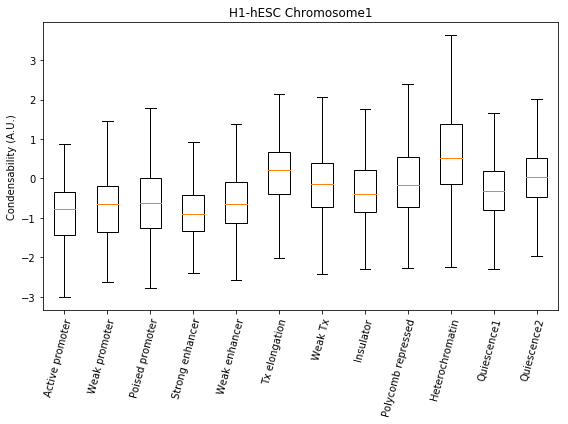

(1, 'H1', 'NCP', 'spd', 6)


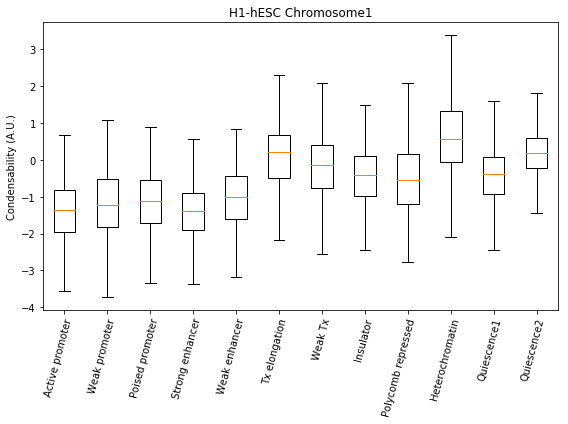

(1, 'H1', 'NCP', 'PEG', 6)


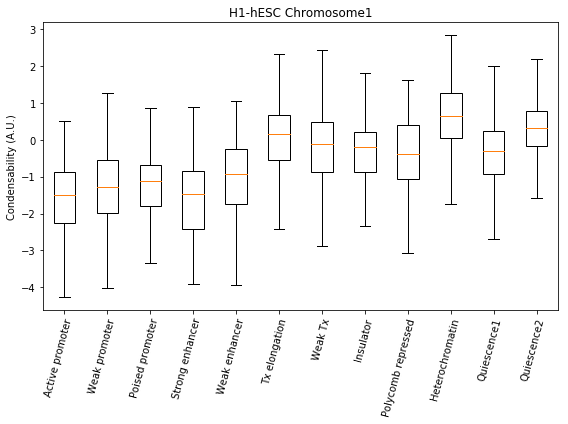

(1, 'H1', 'NCP', 'CoH', 5)


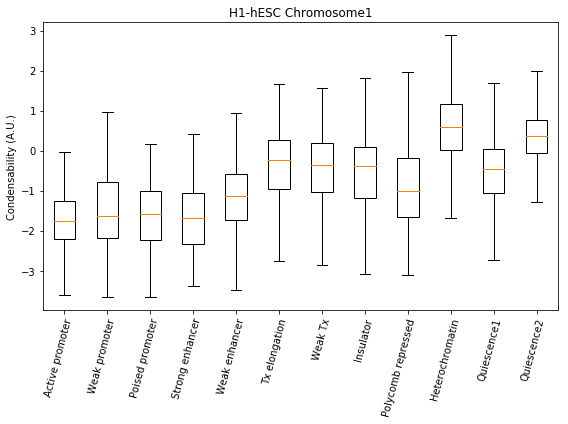

(1, 'H1', 'NCP', 'HP1a', 3)


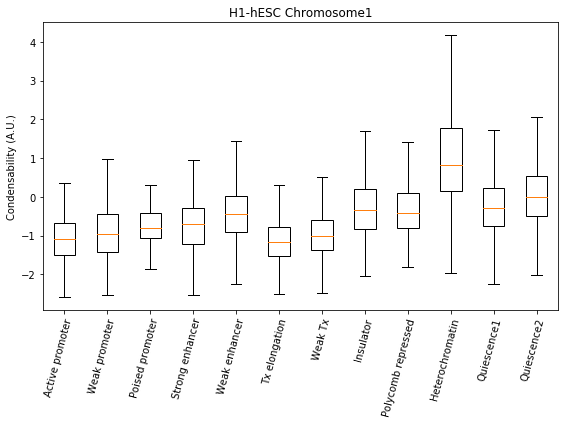

(1, 'H1', 'NCP', 'HP1bSUV', 4)


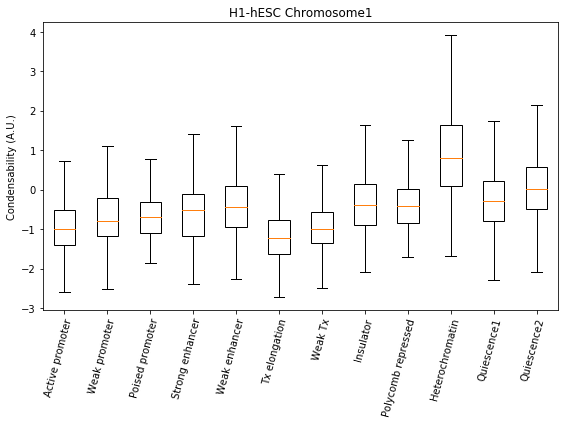

(1, 'H1', 'NCP', 'sp', 8)


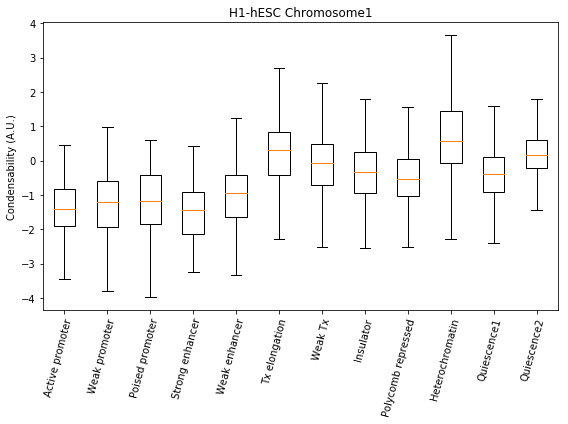

In [22]:
### plot the chromHMM
for dkey in dkey_state_IDs:
    print dkey
    state_IDs = dkey_state_IDs[dkey]
    chr_ID_value = dkey_chr_ID_value[dkey]
    
    state_values = {}
    for state, IDs in state_IDs.items():
        values = [chr_ID_value[ID[0]][ID] for ID in IDs]
        if state not in state_values:
            state_values[state] = []
        state_values[state] += values

    graphics.plot_boxplot (state_values,
                           keys = states,
                           ylabel='Condensability (A.U.)',
                           title='H1-hESC Chromosome1',
                           rotation=75)
    

In [20]:
### statistical testing
testings = ['ttest', 'mannwhitneyu', 'kruskal']
dkey_testing_pair_pvalue = {}
for dkey in dkey_state_IDs:
    state_IDs = dkey_state_IDs[dkey]
    chr_ID_value = dkey_chr_ID_value[dkey]
    
    state_values = {}
    for state, IDs in state_IDs.items():
        values = [chr_ID_value[ID[0]][ID] for ID in IDs]
        if state not in state_values:
            state_values[state] = []
        state_values[state] += values

    testing_pair_pvalue = {}
    for i in range(len(states)-1):
        for j in range(i+1, len(states)):
            
            state1 = states[i]
            state2 = states[j]
            values1 = state_values[state1]
            values2 = state_values[state2]
            
            pair = (state1, state2)
            for testing in testings:
                if testing == 'ttest':
                    pvalue = stats.ttest_ind(values1, values2, equal_var=False)[1]
                elif testing == 'mannwhitneyu':
                    pvalue = stats.mannwhitneyu(values1, values2)[1]
                elif testing == 'kruskal':
                    pvalue = stats.kruskal(values1, values2)[1]

                if testing not in testing_pair_pvalue:
                    testing_pair_pvalue[testing] = {}
                
                assert pair not in testing_pair_pvalue[testing]
                testing_pair_pvalue[testing][pair] = pvalue

    dkey_testing_pair_pvalue[dkey] = testing_pair_pvalue

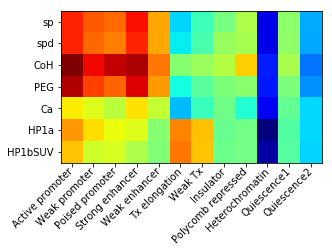

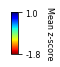

In [36]:
### plot the chromHMM multiple as heatmap
dkeys = [(1, 'H1', 'NCP', 'sp', 8),
         (1, 'H1', 'NCP', 'spd', 6),
         (1, 'H1', 'NCP', 'CoH', 5),
         (1, 'H1', 'NCP', 'PEG', 6),
         (1, 'H1', 'NCP', 'Ca', 5),
         (1, 'H1', 'NCP', 'HP1a', 3),
         (1, 'H1', 'NCP', 'HP1bSUV', 4)]

img = []
for dkey in dkeys:
    row = []
    for state in states:
        mscore = np.mean(dkey_state_values[dkey][state])
        row.append(mscore)
    img.append(row)

cmap = 'jet_r'
vmin, vmax = None, None

width = 0.4*len(states)
height = 0.4*len(dkeys)
fig = plt.figure(figsize=(width, height))
im = plt.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)

plt.xticks(range(len(states)),
           states,
           ha='right',
           va='center',
           rotation_mode='anchor',
           rotation=45)

plt.yticks(range(len(dkeys)),
           [dkey[3] for dkey in dkeys])
#plt.savefig("chrom_meanscore.svg", format='svg', bbox_inches='tight')
#plt.colorbar()
plt.show()
plt.close()

# plot colorbar only
fig = plt.figure(figsize=(1.2,1))
plt.subplot(1,2,1)
cbar = plt.colorbar(im,
                    cax=plt.gca(),
                    ticks=[np.min(img), np.max(img)])
cbar.ax.set_yticklabels([round(np.min(img),1), round(np.max(img),1)],
                        fontsize=8)
cbar.ax.set_ylabel('Mean z-score',
                   rotation=-90,
                   va="bottom",
                   fontsize=8)
plt.tight_layout()
plt.show()
#plt.savefig('chrom_mean_cbar.svg', format='svg', bbox_inches='tight')
plt.close()



ttest
('Active promoter', 'Weak promoter') 0.738788680532237
('Active promoter', 'Poised promoter') 1.4938776304460082
('Active promoter', 'Strong enhancer') 0.17823553866575684
('Active promoter', 'Weak enhancer') 2.3889544008966697
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Weak Tx') 9.999999999996234
('Active promoter', 'Insulator') 9.016556897608059
('Active promoter', 'Polycomb repressed') 9.999995423154768
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence1') 9.999995807497301
('Active promoter', 'Quiescence2') 10.0
('Weak promoter', 'Poised promoter') 0.6311062990682035
('Weak promoter', 'Strong enhancer') 1.1250968179200447
('Weak promoter', 'Weak enhancer') 0.825755840485942
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Weak Tx') 9.999999999913472
('Weak promoter', 'Insulator') 6.592631478235138
('Weak promoter', 'Polycomb repressed') 9.998487596268498
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiesce

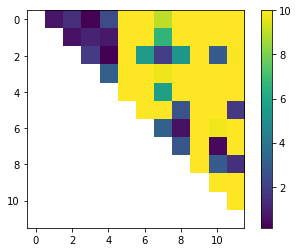


mannwhitneyu
('Active promoter', 'Weak promoter') 0.9468518678872823
('Active promoter', 'Poised promoter') 1.3768953228778662
('Active promoter', 'Strong enhancer') 0.6403175227365759
('Active promoter', 'Weak enhancer') 2.252008594619683
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Weak Tx') 9.99999999999614
('Active promoter', 'Insulator') 8.389274006528378
('Active promoter', 'Polycomb repressed') 9.999743402873891
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence1') 9.999999592836822
('Active promoter', 'Quiescence2') 10.0
('Weak promoter', 'Poised promoter') 0.7770844891855568
('Weak promoter', 'Strong enhancer') 1.4939564411609776
('Weak promoter', 'Weak enhancer') 1.0540453164256032
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Weak Tx') 9.999999999978854
('Weak promoter', 'Insulator') 6.406633089027158
('Weak promoter', 'Polycomb repressed') 9.985306400569785
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', '

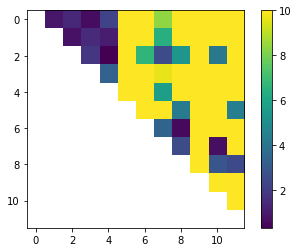


kruskal
('Active promoter', 'Weak promoter') 0.6461244360004755
('Active promoter', 'Poised promoter') 1.0765848404334624
('Active promoter', 'Strong enhancer') 0.3396134404607834
('Active promoter', 'Weak enhancer') 1.9512532294503317
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Weak Tx') 9.999999999992287
('Active promoter', 'Insulator') 8.094653701219382
('Active promoter', 'Polycomb repressed') 9.999488831368138
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence1') 9.999999185778625
('Active promoter', 'Quiescence2') 10.0
('Weak promoter', 'Poised promoter') 0.47643552804789424
('Weak promoter', 'Strong enhancer') 1.1933506414401311
('Weak promoter', 'Weak enhancer') 0.7531555779465152
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Weak Tx') 9.999999999957732
('Weak promoter', 'Insulator') 6.106379947000346
('Weak promoter', 'Polycomb repressed') 9.97116718095091
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Qui

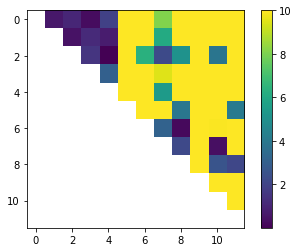


ttest
('Active promoter', 'Weak promoter') 1.6859484089926093
('Active promoter', 'Poised promoter') 1.9142567547767002
('Active promoter', 'Strong enhancer') 0.05688129137752796
('Active promoter', 'Weak enhancer') 6.541344349764592
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Weak Tx') 10.0
('Active promoter', 'Insulator') 10.0
('Active promoter', 'Polycomb repressed') 9.999999993736772
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence1') 10.0
('Active promoter', 'Quiescence2') 10.0
('Weak promoter', 'Poised promoter') 0.2514555958915479
('Weak promoter', 'Strong enhancer') 1.4895152095369422
('Weak promoter', 'Weak enhancer') 1.8615002442381678
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Weak Tx') 10.0
('Weak promoter', 'Insulator') 9.999999969000578
('Weak promoter', 'Polycomb repressed') 9.986431923102943
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence1') 10.0
('Weak promoter', 'Quiescence2') 10.0


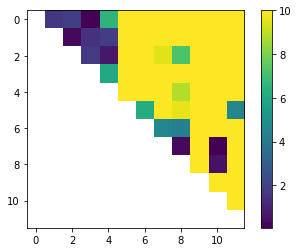


mannwhitneyu
('Active promoter', 'Weak promoter') 1.736750380962058
('Active promoter', 'Poised promoter') 2.185334578904777
('Active promoter', 'Strong enhancer') 0.3516717794110056
('Active promoter', 'Weak enhancer') 6.765954251343291
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Weak Tx') 10.0
('Active promoter', 'Insulator') 9.999999999999979
('Active promoter', 'Polycomb repressed') 9.999999803419959
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence1') 10.0
('Active promoter', 'Quiescence2') 10.0
('Weak promoter', 'Poised promoter') 0.5970168158359521
('Weak promoter', 'Strong enhancer') 1.801567861641208
('Weak promoter', 'Weak enhancer') 2.3518669765904434
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Weak Tx') 10.0
('Weak promoter', 'Insulator') 9.999999744717591
('Weak promoter', 'Polycomb repressed') 9.938595558550404
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence1') 10.0
('Weak promoter', 'Qui

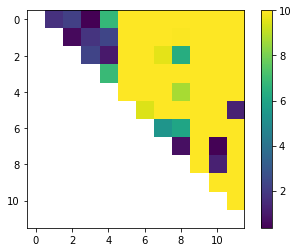


kruskal
('Active promoter', 'Weak promoter') 1.4361578494345588
('Active promoter', 'Poised promoter') 1.8852505487272073
('Active promoter', 'Strong enhancer') 0.050860562104106936
('Active promoter', 'Weak enhancer') 6.465558660630596
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Weak Tx') 10.0
('Active promoter', 'Insulator') 9.99999999999996
('Active promoter', 'Polycomb repressed') 9.999999608445053
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence1') 10.0
('Active promoter', 'Quiescence2') 10.0
('Weak promoter', 'Poised promoter') 0.29630842506583355
('Weak promoter', 'Strong enhancer') 1.501012051412982
('Weak promoter', 'Weak enhancer') 2.0510635348850643
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Weak Tx') 10.0
('Weak promoter', 'Insulator') 9.999999490823495
('Weak promoter', 'Polycomb repressed') 9.885065170768243
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence1') 10.0
('Weak promoter', 'Quie

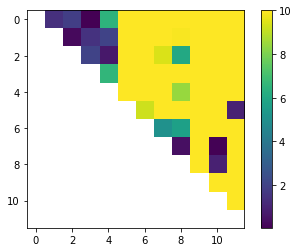


ttest
('Active promoter', 'Weak promoter') 2.3033670948723386
('Active promoter', 'Poised promoter') 2.6902251421600423
('Active promoter', 'Strong enhancer') 0.42068757261774875
('Active promoter', 'Weak enhancer') 8.483909374634516
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Weak Tx') 10.0
('Active promoter', 'Insulator') 10.0
('Active promoter', 'Polycomb repressed') 9.999999999999998
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence1') 10.0
('Active promoter', 'Quiescence2') 10.0
('Weak promoter', 'Poised promoter') 0.3991900526201194
('Weak promoter', 'Strong enhancer') 1.1717059224056858
('Weak promoter', 'Weak enhancer') 2.623929080531456
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Weak Tx') 10.0
('Weak promoter', 'Insulator') 9.99999999998515
('Weak promoter', 'Polycomb repressed') 9.999999847985753
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence1') 10.0
('Weak promoter', 'Quiescence2') 10.0
('

('Strong enhancer', 'Weak Tx') 10.0
('Strong enhancer', 'Insulator') 9.99999999999998
('Strong enhancer', 'Polycomb repressed') 9.999999999944194
('Strong enhancer', 'Heterochromatin') 10.0
('Strong enhancer', 'Quiescence1') 10.0
('Strong enhancer', 'Quiescence2') 10.0
('Weak enhancer', 'Tx elongation') 10.0
('Weak enhancer', 'Weak Tx') 10.0
('Weak enhancer', 'Insulator') 9.999999794701857
('Weak enhancer', 'Polycomb repressed') 9.992856200614233
('Weak enhancer', 'Heterochromatin') 10.0
('Weak enhancer', 'Quiescence1') 10.0
('Weak enhancer', 'Quiescence2') 10.0
('Tx elongation', 'Weak Tx') 5.302042719581914
('Tx elongation', 'Insulator') 5.416371002655608
('Tx elongation', 'Polycomb repressed') 5.46518680264572
('Tx elongation', 'Heterochromatin') 10.0
('Tx elongation', 'Quiescence1') 9.999971362461654
('Tx elongation', 'Quiescence2') 9.959817948844313
('Weak Tx', 'Insulator') 1.1206609571357415
('Weak Tx', 'Polycomb repressed') 1.4833370971763256
('Weak Tx', 'Heterochromatin') 10.0
(

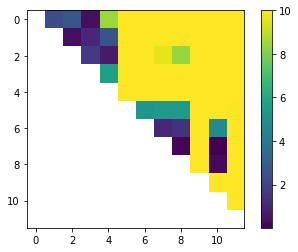


mannwhitneyu
('Active promoter', 'Weak promoter') 2.5638104600547806
('Active promoter', 'Poised promoter') 2.859614968751647
('Active promoter', 'Strong enhancer') 0.4493462514922812
('Active promoter', 'Weak enhancer') 9.450155059391522
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Weak Tx') 10.0
('Active promoter', 'Insulator') 10.0
('Active promoter', 'Polycomb repressed') 9.999999999999911
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence1') 10.0
('Active promoter', 'Quiescence2') 10.0
('Weak promoter', 'Poised promoter') 0.5829778931537928
('Weak promoter', 'Strong enhancer') 1.7275742421683637
('Weak promoter', 'Weak enhancer') 3.4731594535262573
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Weak Tx') 10.0
('Weak promoter', 'Insulator') 9.999999999993875
('Weak promoter', 'Polycomb repressed') 9.999998497329774
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence1') 10.0
('Weak promoter', 'Quiescence2') 

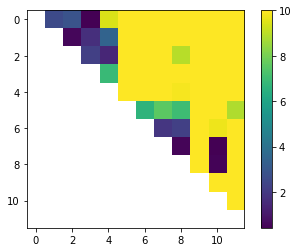


kruskal
('Active promoter', 'Weak promoter') 2.2633294759060387
('Active promoter', 'Poised promoter') 2.5596892972139647
('Active promoter', 'Strong enhancer') 0.14857445387093823
('Active promoter', 'Weak enhancer') 9.215628361578379
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Weak Tx') 10.0
('Active promoter', 'Insulator') 10.0
('Active promoter', 'Polycomb repressed') 9.999999999999824
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence1') 10.0
('Active promoter', 'Quiescence2') 10.0
('Weak promoter', 'Poised promoter') 0.2822645526996999
('Weak promoter', 'Strong enhancer') 1.4270068153455837
('Weak promoter', 'Weak enhancer') 3.1724124505706217
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Weak Tx') 10.0
('Weak promoter', 'Insulator') 9.999999999987788
('Weak promoter', 'Polycomb repressed') 9.999997003902353
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence1') 10.0
('Weak promoter', 'Quiescence2') 10.

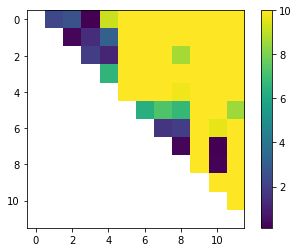


ttest
('Active promoter', 'Weak promoter') 3.3166862685646046
('Active promoter', 'Poised promoter') 1.0628837161174503
('Active promoter', 'Strong enhancer') 0.6988803165739848
('Active promoter', 'Weak enhancer') 9.999999987133613
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Weak Tx') 10.0
('Active promoter', 'Insulator') 10.0
('Active promoter', 'Polycomb repressed') 9.99999999370036
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence1') 10.0
('Active promoter', 'Quiescence2') 10.0
('Weak promoter', 'Poised promoter') 0.5563182865035439
('Weak promoter', 'Strong enhancer') 1.2878854850657337
('Weak promoter', 'Weak enhancer') 5.171154287585949
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Weak Tx') 10.0
('Weak promoter', 'Insulator') 9.999999999999996
('Weak promoter', 'Polycomb repressed') 8.412459068825402
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence1') 10.0
('Weak promoter', 'Quiescence2') 10.0
('P

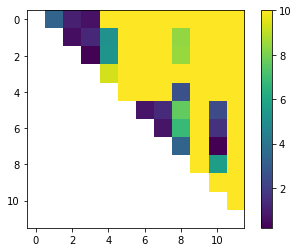


mannwhitneyu
('Active promoter', 'Weak promoter') 2.4366619058764467
('Active promoter', 'Poised promoter') 1.358978355588862
('Active promoter', 'Strong enhancer') 0.8422550584968477
('Active promoter', 'Weak enhancer') 9.99999916729846
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Weak Tx') 10.0
('Active promoter', 'Insulator') 10.0
('Active promoter', 'Polycomb repressed') 9.999997964101706
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence1') 10.0
('Active promoter', 'Quiescence2') 10.0
('Weak promoter', 'Poised promoter') 0.6778136195457589
('Weak promoter', 'Strong enhancer') 1.2819387366764965
('Weak promoter', 'Weak enhancer') 5.914004872983155
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Weak Tx') 10.0
('Weak promoter', 'Insulator') 9.999999999999934
('Weak promoter', 'Polycomb repressed') 7.954917018552735
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence1') 10.0
('Weak promoter', 'Quiescence2') 10

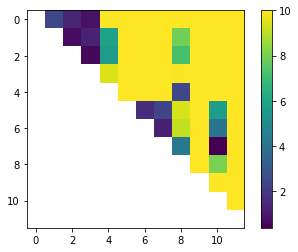


kruskal
('Active promoter', 'Weak promoter') 2.1361650804837677
('Active promoter', 'Poised promoter') 1.058662200493192
('Active promoter', 'Strong enhancer') 0.5416133496332272
('Active promoter', 'Weak enhancer') 9.999998337642474
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Weak Tx') 10.0
('Active promoter', 'Insulator') 10.0
('Active promoter', 'Polycomb repressed') 9.999995944288914
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence1') 10.0
('Active promoter', 'Quiescence2') 10.0
('Weak promoter', 'Poised promoter') 0.37713276770297105
('Weak promoter', 'Strong enhancer') 0.9812955026017379
('Weak promoter', 'Weak enhancer') 5.613372447384183
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Weak Tx') 10.0
('Weak promoter', 'Insulator') 9.999999999999869
('Weak promoter', 'Polycomb repressed') 7.656785291036592
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence1') 10.0
('Weak promoter', 'Quiescence2') 10.0


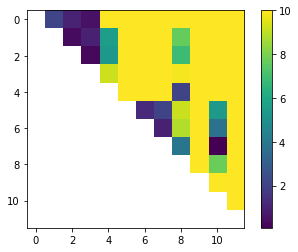


ttest
('Active promoter', 'Weak promoter') 2.5228514385757714
('Active promoter', 'Poised promoter') 4.306482729742542
('Active promoter', 'Strong enhancer') 5.313118451137319
('Active promoter', 'Weak enhancer') 9.999999999999718
('Active promoter', 'Tx elongation') 0.3567171214963897
('Active promoter', 'Weak Tx') 1.5141021983761882
('Active promoter', 'Insulator') 9.99999999999999
('Active promoter', 'Polycomb repressed') 9.999999999994666
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence1') 10.0
('Active promoter', 'Quiescence2') 10.0
('Weak promoter', 'Poised promoter') 0.832868870931764
('Weak promoter', 'Strong enhancer') 1.3905862467190329
('Weak promoter', 'Weak enhancer') 9.999894213251123
('Weak promoter', 'Tx elongation') 5.731289968187339
('Weak promoter', 'Weak Tx') 1.1934926113252775
('Weak promoter', 'Insulator') 9.99999771181442
('Weak promoter', 'Polycomb repressed') 9.999399772929795
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter

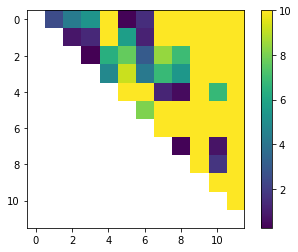


mannwhitneyu
('Active promoter', 'Weak promoter') 2.236891961923868
('Active promoter', 'Poised promoter') 4.860441096667214
('Active promoter', 'Strong enhancer') 5.823303535233237
('Active promoter', 'Weak enhancer') 9.999999999999991
('Active promoter', 'Tx elongation') 0.8065465655006289
('Active promoter', 'Weak Tx') 1.840423741604489
('Active promoter', 'Insulator') 9.999999999999963
('Active promoter', 'Polycomb repressed') 9.999999999997037
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence1') 10.0
('Active promoter', 'Quiescence2') 10.0
('Weak promoter', 'Poised promoter') 1.5851731089152772
('Weak promoter', 'Strong enhancer') 2.0838618645133216
('Weak promoter', 'Weak enhancer') 9.999998167226986
('Weak promoter', 'Tx elongation') 5.3641041449506135
('Weak promoter', 'Weak Tx') 1.0142033860879012
('Weak promoter', 'Insulator') 9.999999146836116
('Weak promoter', 'Polycomb repressed') 9.999873962310733
('Weak promoter', 'Heterochromatin') 10.0
('Weak


('Tx elongation', 'Insulator') 10.0
('Tx elongation', 'Polycomb repressed') 10.0
('Tx elongation', 'Heterochromatin') 10.0
('Tx elongation', 'Quiescence1') 10.0
('Tx elongation', 'Quiescence2') 10.0
('Weak Tx', 'Insulator') 10.0
('Weak Tx', 'Polycomb repressed') 10.0
('Weak Tx', 'Heterochromatin') 10.0
('Weak Tx', 'Quiescence1') 10.0
('Weak Tx', 'Quiescence2') 10.0
('Insulator', 'Polycomb repressed') 0.59334270592115
('Insulator', 'Heterochromatin') 10.0
('Insulator', 'Quiescence1') 1.0893516855788328
('Insulator', 'Quiescence2') 9.989657270914476
('Polycomb repressed', 'Heterochromatin') 10.0
('Polycomb repressed', 'Quiescence1') 1.8666358046369584
('Polycomb repressed', 'Quiescence2') 9.999664197925751
('Heterochromatin', 'Quiescence1') 10.0
('Heterochromatin', 'Quiescence2') 10.0
('Quiescence1', 'Quiescence2') 10.0


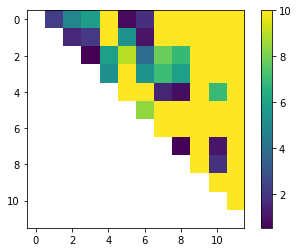


kruskal
('Active promoter', 'Weak promoter') 1.9363693934341526
('Active promoter', 'Poised promoter') 4.560898808917816
('Active promoter', 'Strong enhancer') 5.523487187305052
('Active promoter', 'Weak enhancer') 9.999999999999982
('Active promoter', 'Tx elongation') 0.5056448247856227
('Active promoter', 'Weak Tx') 1.539478378770011
('Active promoter', 'Insulator') 9.999999999999924
('Active promoter', 'Polycomb repressed') 9.9999999999941
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence1') 10.0
('Active promoter', 'Quiescence2') 10.0
('Weak promoter', 'Poised promoter') 1.2847340688802926
('Weak promoter', 'Strong enhancer') 1.7833483534594958
('Weak promoter', 'Weak enhancer') 9.999996339790666
('Weak promoter', 'Tx elongation') 5.063393983059828
('Weak promoter', 'Weak Tx') 0.7132222992071297
('Weak promoter', 'Insulator') 9.999998298234432
('Weak promoter', 'Polycomb repressed') 9.999748683644906
('Weak promoter', 'Heterochromatin') 10.0
('Weak promot

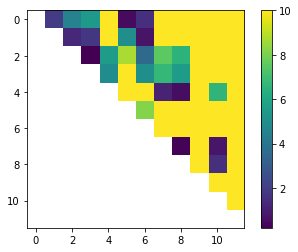


ttest
('Active promoter', 'Weak promoter') 3.8209305420684188
('Active promoter', 'Poised promoter') 2.538218706583413
('Active promoter', 'Strong enhancer') 5.613488278850405
('Active promoter', 'Weak enhancer') 9.999997577930571
('Active promoter', 'Tx elongation') 3.8590200121796974
('Active promoter', 'Weak Tx') 0.06410542740105665
('Active promoter', 'Insulator') 9.999991136132481
('Active promoter', 'Polycomb repressed') 9.999979285938464
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence1') 10.0
('Active promoter', 'Quiescence2') 10.0
('Weak promoter', 'Poised promoter') 0.148789025470245
('Weak promoter', 'Strong enhancer') 0.8050251675366095
('Weak promoter', 'Weak enhancer') 5.232695062897699
('Weak promoter', 'Tx elongation') 9.999999997840732
('Weak promoter', 'Weak Tx') 7.570563633743677
('Weak promoter', 'Insulator') 5.586318886576642
('Weak promoter', 'Polycomb repressed') 5.210470622935067
('Weak promoter', 'Heterochromatin') 10.0
('Weak promot

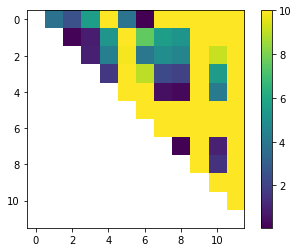


mannwhitneyu
('Active promoter', 'Weak promoter') 3.7156104490513795
('Active promoter', 'Poised promoter') 3.0519940429829435
('Active promoter', 'Strong enhancer') 5.706459428319568
('Active promoter', 'Weak enhancer') 9.999998989636952
('Active promoter', 'Tx elongation') 4.618570749393367
('Active promoter', 'Weak Tx') 0.32384466575326254
('Active promoter', 'Insulator') 9.999951151107805
('Active promoter', 'Polycomb repressed') 9.99998145820896
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence1') 10.0
('Active promoter', 'Quiescence2') 10.0
('Weak promoter', 'Poised promoter') 0.3892660871827092
('Weak promoter', 'Strong enhancer') 1.3840859215147738
('Weak promoter', 'Weak enhancer') 6.568275579669047
('Weak promoter', 'Tx elongation') 9.999999999930697
('Weak promoter', 'Weak Tx') 7.557961958600722
('Weak promoter', 'Insulator') 6.4688927707786394
('Weak promoter', 'Polycomb repressed') 6.236795070388638
('Weak promoter', 'Heterochromatin') 10.0
('Wea

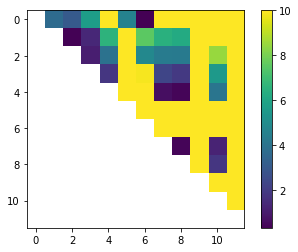


kruskal
('Active promoter', 'Weak promoter') 3.415258102308831
('Active promoter', 'Poised promoter') 2.752110026148439
('Active promoter', 'Strong enhancer') 5.406626499749306
('Active promoter', 'Weak enhancer') 9.999997982959343
('Active promoter', 'Tx elongation') 4.317900181998559
('Active promoter', 'Weak Tx') 0.022842652323641126
('Active promoter', 'Insulator') 9.999902621652263
('Active promoter', 'Polycomb repressed') 9.99996305875006
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence1') 10.0
('Active promoter', 'Quiescence2') 10.0
('Weak promoter', 'Poised promoter') 0.08847817856766185
('Weak promoter', 'Strong enhancer') 1.083461068884349
('Weak promoter', 'Weak enhancer') 6.26772792163546
('Weak promoter', 'Tx elongation') 9.999999999861595
('Weak promoter', 'Weak Tx') 7.257872013877888
('Weak promoter', 'Insulator') 6.168651950563647
('Weak promoter', 'Polycomb repressed') 5.936627216931682
('Weak promoter', 'Heterochromatin') 10.0
('Weak promot

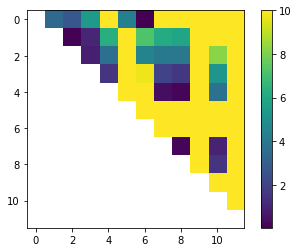


ttest
('Active promoter', 'Weak promoter') 1.2088806597897013
('Active promoter', 'Poised promoter') 1.2150343873367846
('Active promoter', 'Strong enhancer') 0.2508342909252362
('Active promoter', 'Weak enhancer') 6.322355302646041
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Weak Tx') 10.0
('Active promoter', 'Insulator') 10.0
('Active promoter', 'Polycomb repressed') 9.999999992374914
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence1') 10.0
('Active promoter', 'Quiescence2') 10.0
('Weak promoter', 'Poised promoter') 0.1677585998608764
('Weak promoter', 'Strong enhancer') 1.8888279780853492
('Weak promoter', 'Weak enhancer') 2.6622961368132074
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Weak Tx') 10.0
('Weak promoter', 'Insulator') 9.99999999999999
('Weak promoter', 'Polycomb repressed') 9.99964311389225
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence1') 10.0
('Weak promoter', 'Quiescence2') 10.0
('P

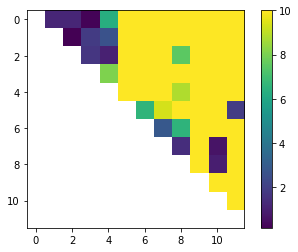


mannwhitneyu
('Active promoter', 'Weak promoter') 1.2803936937185496
('Active promoter', 'Poised promoter') 1.4611347575478901
('Active promoter', 'Strong enhancer') 0.666061856019041
('Active promoter', 'Weak enhancer') 6.918104442491411
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Weak Tx') 10.0
('Active promoter', 'Insulator') 10.0
('Active promoter', 'Polycomb repressed') 9.99999989028764
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence1') 10.0
('Active promoter', 'Quiescence2') 10.0
('Weak promoter', 'Poised promoter') 0.531958487305369
('Weak promoter', 'Strong enhancer') 2.0453369770086405
('Weak promoter', 'Weak enhancer') 3.205894020202907
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Weak Tx') 10.0
('Weak promoter', 'Insulator') 9.999999999999682
('Weak promoter', 'Polycomb repressed') 9.996596861719288
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence1') 10.0
('Weak promoter', 'Quiescence2') 10.

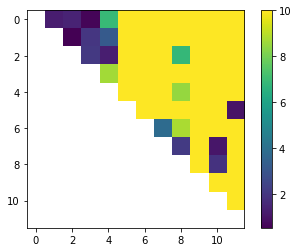


kruskal
('Active promoter', 'Weak promoter') 0.9797280567436323
('Active promoter', 'Poised promoter') 1.160850476480235
('Active promoter', 'Strong enhancer') 0.36536617607364097
('Active promoter', 'Weak enhancer') 6.617768099596708
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Weak Tx') 10.0
('Active promoter', 'Insulator') 10.0
('Active promoter', 'Polycomb repressed') 9.999999781478298
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence1') 10.0
('Active promoter', 'Quiescence2') 10.0
('Weak promoter', 'Poised promoter') 0.23122670160911182
('Weak promoter', 'Strong enhancer') 1.7448178674264292
('Weak promoter', 'Weak enhancer') 2.905134498225079
('Weak promoter', 'Tx elongation') 10.0
('Weak promoter', 'Weak Tx') 10.0
('Weak promoter', 'Insulator') 9.999999999999368
('Weak promoter', 'Polycomb repressed') 9.993238370739983
('Weak promoter', 'Heterochromatin') 10.0
('Weak promoter', 'Quiescence1') 10.0
('Weak promoter', 'Quiescence2') 10.0

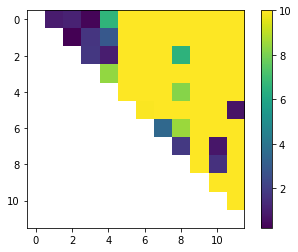

In [21]:
for dkey in dkey_testing_pair_pvalue:
    for testing in testings:
        print testing
        
        pair_pvalue = dkey_testing_pair_pvalue[dkey][testing]

        img = []
        for i in range(len(states)):
            row = []
            for j in range(len(states)):
                try:
                    pair = (states[i], states[j])
                    pvalue = pair_pvalue[pair] + 10**-10
                    logpvalue = -np.log10(pvalue)
                    print pair, logpvalue
                except:
                    logpvalue = np.nan
                row.append(logpvalue)
            img.append(row)

        fig = plt.figure()
        plt.imshow(img)
        plt.colorbar()
        plt.show()
        plt.close()

        print
        